# Heart Rate Analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/main/docs/src/tutorials/heart_rate_analysis.ipynb)

In this notebook shows how to load, visualize, and process medical data with Temporian. By the end of the notebook, we will have created a Temporian program to **detect heartbeats** from raw [ECG](https://en.wikipedia.org/wiki/Electrocardiography) signal, and to compute the **heart rate** and **heart rate variability**.
We will use the ECG and respiratory waveforms data from three patients from the [Apnea-ECG](https://www.physionet.org/content/apnea-ecg/1.0.0/) dataset.

## Install and import dependencies

In [1]:
%pip install temporian -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# The WFDB package (https://wfdb.readthedocs.io) can download physiological datasets from physionet.org. 
%pip install wfdb -q

# The Bokeh package is used by Temporian to create interactive plots.
# If if Bokeh is not installed, Temporian plots are static.
%pip install bokeh -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import temporian as tp

import os
import wfdb
import pandas as pd
import numpy as np

from typing import Tuple, List

## Download patient data

Download the data of the patients `a1-3`. Records `a1-3`contain ECG and records `a1-3r` contain the respiratory signals.

In [4]:
patients = ["a01", "a02", "a03"]

tmp_directory = "tmp/temporian_vital_signs"
if not os.path.isdir(tmp_directory):
    wfdb.dl_database(
        "apnea-ecg",
        dl_dir=tmp_directory,
        records=patients + [f"{p}r" for p in patients],
    )

## Convert patient data to PhysioNet to Temporian format

Convert the PhysioNet ECG and respiratory records from the three patients into two single Temporian event set.

In [5]:
def wfdb_to_pandas(key: str) -> pd.DataFrame:
    """Convert the PhysioNet into a Pandas DataFrame.""" 

    # Raw signals.
    signals, medadata = wfdb.rdsamp(f"{tmp_directory}/{key}")
    df = pd.DataFrame(signals, columns=medadata["sig_name"])

    # Generate timestamps
    df["timestamp"] = np.arange(medadata["sig_len"]) / medadata["fs"]

    return df

wfdb_to_pandas("a01").head()

,ECG,timestamp
0,-0.060,0.00
1,-0.065,0.01
2,-0.060,0.02
3,-0.075,0.03
4,-0.065,0.04


In [6]:
def load_all_patients(patients: List[str]) -> Tuple[tp.EventSet, tp.EventSet]:

    ecg_dfs = [wfdb_to_pandas(p) for p in patients]
    res_dfs = [wfdb_to_pandas(p + "r") for p in patients]

    merged_ecg_dfs = pd.concat([d.assign(patient=p) for d, p in zip(ecg_dfs, patients)])
    merged_res_dfs = pd.concat([d.assign(patient=p) for d, p in zip(res_dfs, patients)])
    
    return (
        tp.from_pandas(merged_ecg_dfs, indexes=["patient"]),
        tp.from_pandas(merged_res_dfs, indexes=["patient"]),
    )

ecg_evset, resp_evset = load_all_patients(patients)

`ecg_evset`contains the ECG data indexed by patient.

In [7]:
ecg_evset

indexes: [('patient', str_)]
features: [('ECG', float64)]
events:
    patient=b'a01' (2957000 events):
        timestamps: [0.000e+00 1.000e-02 2.000e-02 ... 2.957e+04 2.957e+04 2.957e+04]
        'ECG': [-0.06  -0.065 -0.06  ...  0.     0.     0.   ]
    patient=b'a02' (3182000 events):
        timestamps: [0.000e+00 1.000e-02 2.000e-02 ... 3.182e+04 3.182e+04 3.182e+04]
        'ECG': [-0.02  -0.02  -0.025 ...  0.     0.     0.   ]
    patient=b'a03' (3135000 events):
        timestamps: [0.000e+00 1.000e-02 2.000e-02 ... 3.135e+04 3.135e+04 3.135e+04]
        'ECG': [-0.23  -0.105  0.    ...  0.     0.     0.   ]
memory usage: 148.4 MB

`resp_evset` contains the respiratory signals indexed by patient.

In [8]:
resp_evset

indexes: [('patient', str_)]
features: [('Resp C', float64), ('Resp A', float64), ('Resp N', float64), ('SpO2', float64)]
events:
    patient=b'a01' (2956796 events):
        timestamps: [0.0000e+00 1.0000e-02 2.0000e-02 ... 2.9568e+04 2.9568e+04 2.9568e+04]
        'Resp C': [-0.1015 -0.1025 -0.1035 ...  0.      0.      0.    ]
        'Resp A': [-0.3446 -0.3455 -0.3464 ...  0.      0.      0.    ]
        'Resp N': [0.2354 0.2364 0.2374 ... 0.     0.     0.    ]
        'SpO2': [98. 98. 98. ...  0.  0.  0.]
    patient=b'a02' (3181796 events):
        timestamps: [0.0000e+00 1.0000e-02 2.0000e-02 ... 3.1818e+04 3.1818e+04 3.1818e+04]
        'Resp C': [-0.0853 -0.0843 -0.0834 ...  0.      0.      0.    ]
        'Resp A': [0.22   0.2092 0.1983 ... 0.     0.     0.    ]
        'Resp N': [-0.4189 -0.4093 -0.3998 ...  0.      0.      0.    ]
        'SpO2': [96. 96. 96. ...  0.  0.  0.]
    patient=b'a03' (3134796 events):
        timestamps: [0.0000e+00 1.0000e-02 2.0000e-02 ... 3.134

## Data processing and visualization

Plotting is a great way to understand the data and spot issues.

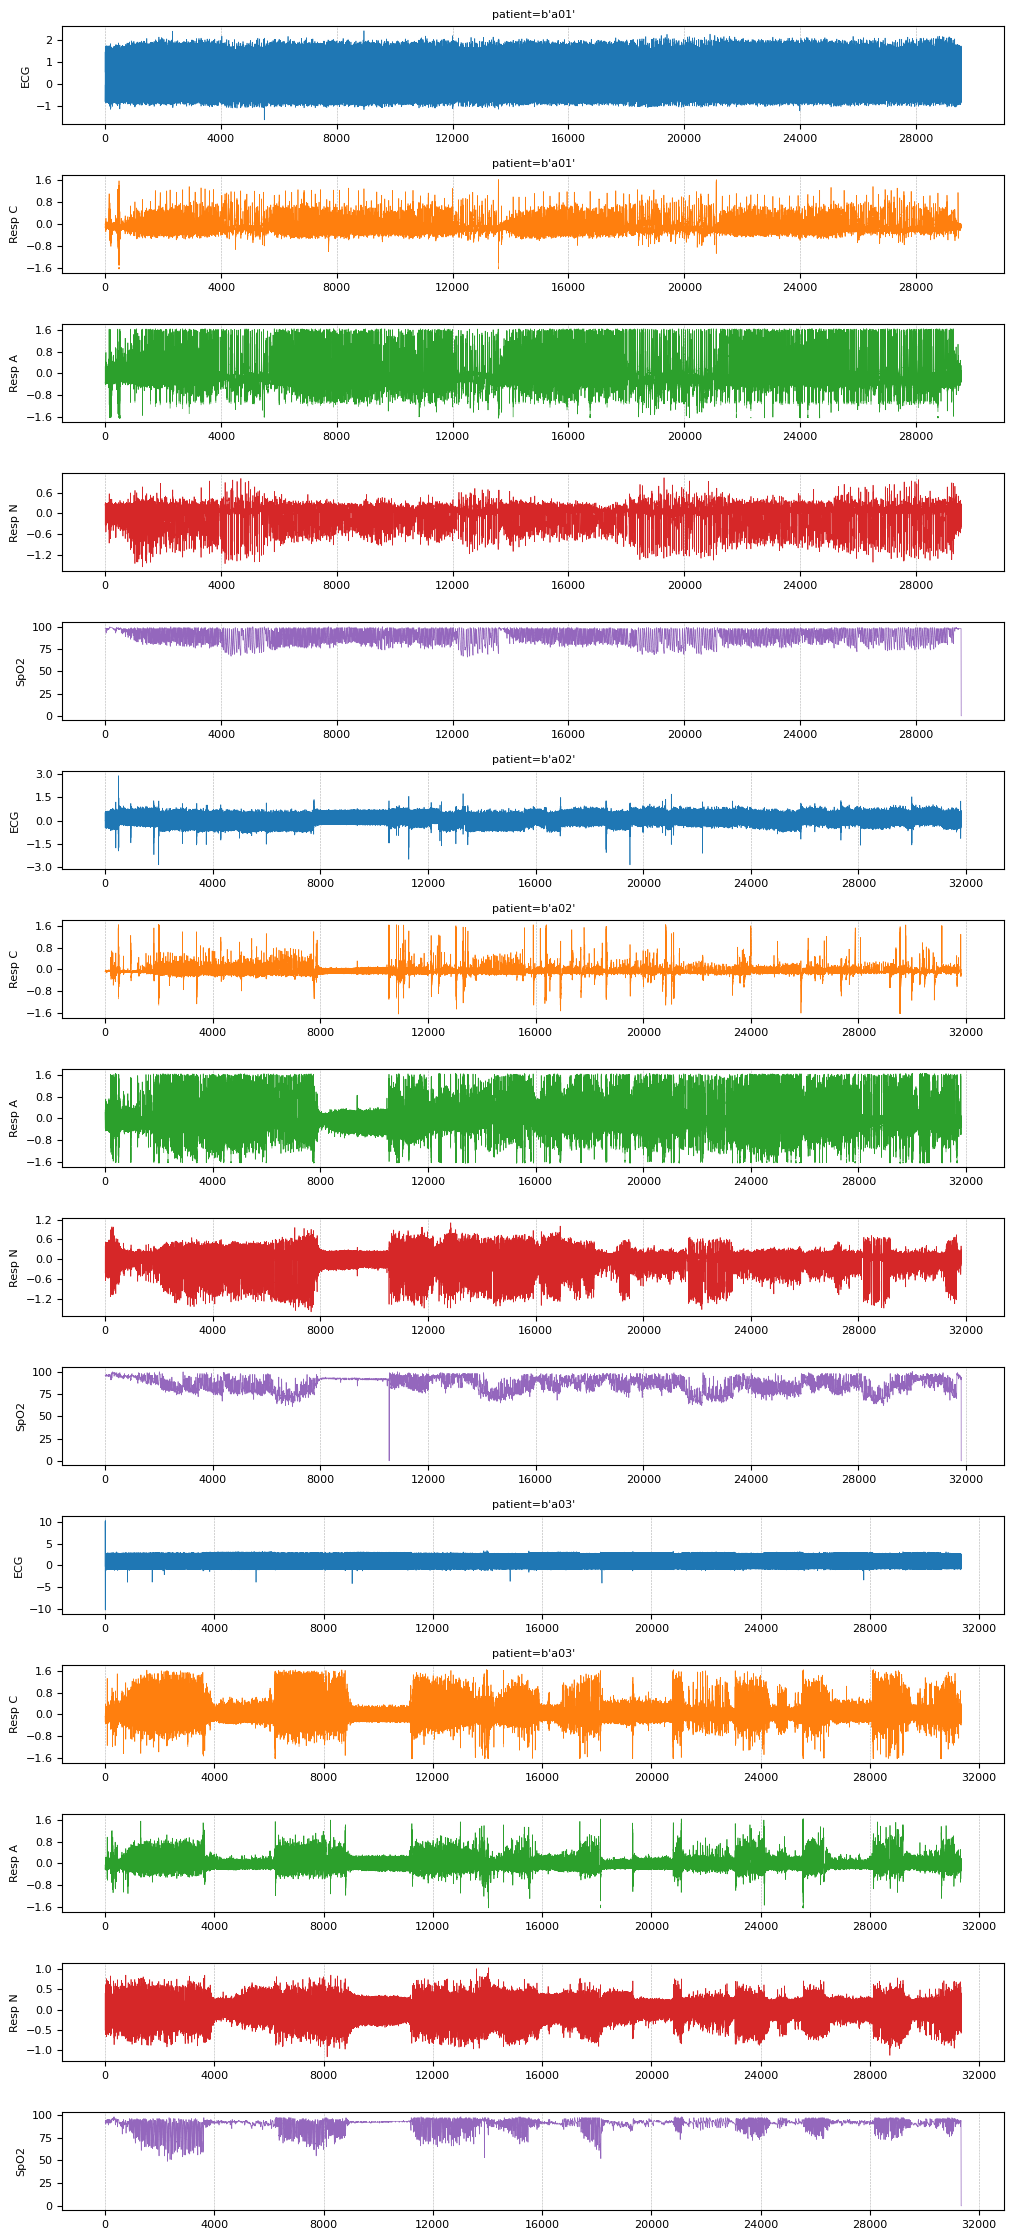

In [9]:
tp.plot([ecg_evset, resp_evset])

# Alternatively, individual EventSets can also be plotted individually with:
#   ecg_evset.plot()
#   resp_evset.plot()

The ranges of values look correct. For example, SpO2 is between 0 and 100, and most of the time close to 100 for a patient in good health.
However, we cannot see details. Let's simplify the plot by only looking at the first 20 seconds of data for the first patient.
In addition, let's enable interactive plotting with `interactive=True`.

**Remarks:**
- Interactive plotting is not suited to print large amount of data like in the plot above. It will make the plot unresponsive.
- Temporian uses the Bokeh library for interactive plotting. Bokeh need to be separately with `pip install bokeh`.
- Try to zoom and pan in the interactive plots. Looking closely at the data is often interesting.

In [10]:
plot_args = {
    "min_time": 0,        # Start time of the plotting
    "max_time": 20,       # End time of the plotting
    "indexes": "a01",     # Restrict the plotting to patient "a01"
    "interactive": True,  # Enable interactive plotting
    "width_px": 500,      # Make sure controls are visible
}
tp.plot([ecg_evset, resp_evset], **plot_args)

The heartbeats are visible on the `ECG` feature: Each large up spike is a beat.
The respiration cycles are also visible on the `Resp*` features.

The ECG data is sampled at 100Hz, that is, we have 100 events with an `ECG` value every second.
To compute heart rate, we first need to detect the heart beats.

We are using the following criteria. There is a heartbeat if both of these conditions are met:

**Criterion #1**

The ECG value is above 70% of the moving range over the last 3 seconds.
Precisely, the ECG is above `mmin + (mmax - mmin) * 0.7` where `mmin` and `mmax` are the moving minimum and maximum.

**Criterion #2**

The last heartbeat was detected at least 60/200=300ms ago.
It means we cannot detect heart beat above 200bpm, but this is a simple way to remove most of the noise.

Let's convert the criteria into a Temporian program.

In [11]:
# Moving minimum, maximum and range of the ECG
mmin = tp.moving_min(ecg_evset, 3.0)
mmax = tp.moving_max(ecg_evset, 3.0)
mrange = mmax - mmin

# Build a boolean feature indicating if the criterion 1 is true.
# TODO: Replace with "ecg_evset > mmin + ecg_mrange * 0.7"
criterion_1_is_valid = ecg_evset - (mmin + mrange * 0.7) > 0.0

# Filter the events where criterion 1 is not true.
criterion_1_candidates = tp.filter(criterion_1_is_valid)

# Build a boolean feature indicating if the criterion 2 is true.
#
# The criterion 2 is only computed for the events where criterion 1 is valid.
criterion_2_is_valid = tp.since_last(criterion_1_candidates) > 60.0 / 200

# Filter the events where criterion 1 + 2 is not true.
heart_beats = tp.filter(criterion_2_is_valid)

# Rename the new created feature "heart beat" to make nice plots.
heart_beats = tp.rename(heart_beats, "heart beat")


In [12]:
# The list of the signals to plot. During development, it is useful to plot
# the intermediate results.
to_plot = [
    ecg_evset,
    tp.rename(criterion_1_is_valid, "criterion_1_is_valid"),
    tp.rename(criterion_1_candidates, "criterion_1_candidates"),
    tp.rename(criterion_2_is_valid, "criterion_2_is_valid"),
    heart_beats,
]

tp.plot(to_plot, **plot_args)

From the **heartbeat** events, we can compute the **heart rate** and **heart rate variability**.
Those are two important measures to monitor patient health.

The **heart rate** is computed by counting the number of beats in 60 seconds and expressed in beats-per-minutes (bpm).

**Note:** The heart rate can also be computed by counting the number of beats in a shorter window (e.g. 20 seconds) and multiplying the number to get a number of beats per seconds.

In [13]:
# Number of events in the last 60 seconds.
heart_rate = tp.moving_count(heart_beats, tp.duration.seconds(60))
heart_rate = tp.rename(heart_rate, "heart rate")

to_plot = [
    heart_beats,
    heart_rate,
]

tp.plot(
    to_plot,
    min_time=0,
    max_time=tp.duration.hours(6),
    indexes="a01",
    interactive=True,
    width_px=plot_args["width_px"]
)

One way to compute the heart rate variability (HRV) is using the standard deviation of the interval between successive heart beats (called RR interval) and expressed in ms. We can compute it over 60s like for the heart beat or with a longer time windows for more stability (e.g., 240 seconds)

In [14]:
# Time since the last event.
rr_interval = tp.since_last(heart_beats)

heart_rate_variability = tp.moving_standard_deviation(rr_interval, 240.0) * 1000.0
heart_rate_variability = tp.rename(heart_rate_variability, "heart rate variability")

to_plot = [
    heart_beats,
    heart_rate,
    heart_rate_variability,
]

tp.plot(
    to_plot,
    min_time=0,
    max_time=tp.duration.hours(6),
    indexes="a01",
    interactive=True,
    width_px=plot_args["width_px"]
)

Currently, heart rate and heart rate variability are calculated at every heartbeat, resulting in a large amount of non-uniform sampled data. To enhance compatibility with other systems, a better approach is to compute the heart rate at a regular internal (e.g., every 10 seconds).

- `tp.tick` generates uniformly sampled timestamps.
- `tp.resample` samples a feature using the timestamps of another node.

**Note:**

- Window functions like tp.`moving_count` have an optional `sampling` argument which is equivalent, but more efficient than calling `tp.moving_count` and `tp.resample` separately. Our dataset is small enought that it does not matter.
- The plotting functions (e.g., `tp.plot`) select automatically the plotting style according to the data. Uniformly sampled features are plotted with a continuous line, while non-uniformly sampled features are plotted with dots.

In [15]:
# A unique sampling every 10s
uniform_sampling_10s = tp.tick(heart_rate, interval=tp.duration.seconds(10))

# Resample the heart rate every 10 seconds.
heart_rate_every_10s = tp.resample(heart_rate, sampling=uniform_sampling_10s)
heart_rate_every_10s = tp.rename(heart_rate_every_10s, "heart rate (10s)")

# Resample the heart rate variability every 10 seconds.
heart_rate_variability_every_10s = tp.resample(heart_rate_variability, sampling=uniform_sampling_10s)
heart_rate_variability_every_10s = tp.rename(heart_rate_variability_every_10s, "heart rate variability (10s)")

to_plot = [
    uniform_sampling_10s,
    heart_beats,
    heart_rate,
    heart_rate_every_10s,
    heart_rate_variability,
    heart_rate_variability_every_10s,
]

tp.plot(
    to_plot,
    min_time=500,
    max_time=560,
    indexes="a01",
    interactive=True,
    width_px=plot_args["width_px"]
)

Let's now visualize other patients and not just index `patient=a01`.

In [16]:
to_plot = [
    heart_rate_every_10s,
    heart_rate_variability_every_10s,
]

tp.plot(to_plot, interactive=True, width_px=plot_args["width_px"])

## Save / Load Temporian program

Temporian programs can be saved to a file to be re-loaded later. In order to do that, we need to copy all the calculations inside a single function, which can calculate all the desired outputs from the input arguments.

In this case, the function will receive an argument `ecg` that represents our `ecg_evset`, and then it will perform all the operations from it and return a dictionary with all the outputs we want to use later.

### Compiling a function
To save a function, we need to decorate it with `@tp.compile`. This will tell Temporian to avoid executing each of the operations at each step (aka eager mode), and instead create a computation graph that can be evaluated in one single run, or saved for later usage.

Compiled functions can also be useful to speed up chained operations, once they're properly defined.

Let's copy all the above operations inside of one single function `detect_heart_beats(ecg)` and evaluate it to verify it works.

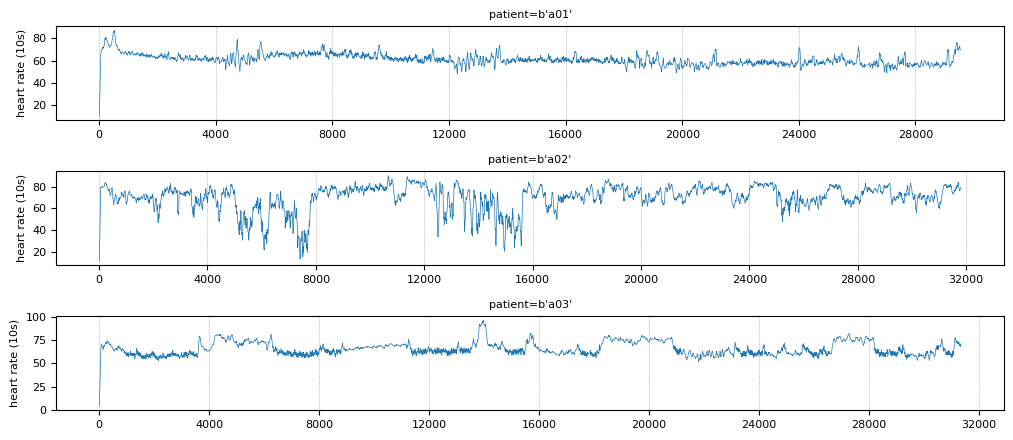

In [17]:
@tp.compile
def detect_heart_beats(ecg):
    # Moving minimum, maximum and range of the ECG
    mmin = tp.moving_min(ecg, 3.0)
    mmax = tp.moving_max(ecg, 3.0)
    mrange = mmax - mmin
    
    # Build a boolean feature indicating if the criterion 1 is true.
    criterion_1_is_valid = ecg - (mmin + mrange * 0.7) > 0.0
    
    # Filter the events where criterion 1 is not true.
    criterion_1_candidates = tp.filter(criterion_1_is_valid)
    
    # Build a boolean feature indicating if the criterion 2 is true.
    #
    # The criterion 2 is only computed for the events where criterion 1 is valid.
    criterion_2_is_valid = tp.since_last(criterion_1_candidates) > 60.0 / 200
    
    # Filter the events where criterion 1 + 2 is not true.
    heart_beats = tp.filter(criterion_2_is_valid)
    
    # Rename the new created feature "heart beat" to make nice plots.
    heart_beats = tp.rename(heart_beats, "heart beat")
    # Number of events in the last 60 seconds.
    heart_rate = tp.moving_count(heart_beats, tp.duration.seconds(60))
    heart_rate = tp.rename(heart_rate, "heart rate")
    
    # Time since the last event.
    rr_interval = tp.since_last(heart_beats)
    
    heart_rate_variability = tp.moving_standard_deviation(rr_interval, 240.0) * 1000.0
    heart_rate_variability = tp.rename(heart_rate_variability, "heart rate variability")
    # A unique sampling every 10s
    uniform_sampling_10s = tp.tick(heart_rate, interval=tp.duration.seconds(10))
    
    # Resample the heart rate every 10 seconds.
    heart_rate_every_10s = tp.resample(heart_rate, sampling=uniform_sampling_10s)
    heart_rate_every_10s = tp.rename(heart_rate_every_10s, "heart rate (10s)")
    
    # Resample the heart rate variability every 10 seconds.
    heart_rate_variability_every_10s = tp.resample(heart_rate_variability, sampling=uniform_sampling_10s)
    heart_rate_variability_every_10s = tp.rename(heart_rate_variability_every_10s, "heart rate variability (10s)")

    return {
        "hb": heart_beats,
        "hr": heart_rate_every_10s,
        "hrv": heart_rate_variability_every_10s,
    }

# Check that the function works like the above computations
results_orig = detect_heart_beats(ecg_evset)
results_orig["hr"].plot()

### Saving and loading the compiled function

Now, we can save and then reload the function from a file. And then, evaluate the results using the reloaded function and check they're exactly the same as with the original function.

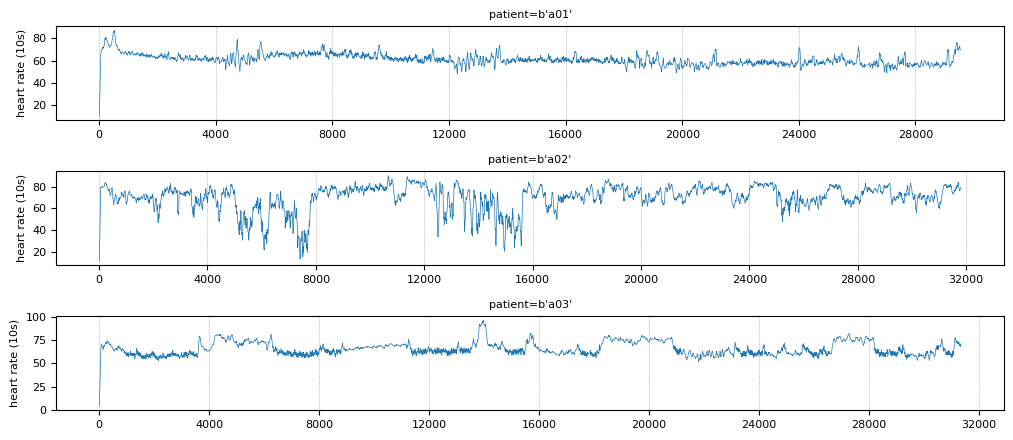

In [18]:
tp.save(detect_heart_beats, "tmp/heart_graph.tem", ecg_evset)

detect_heart_beats_reloaded = tp.load("tmp/heart_graph.tem")

results_reloaded = detect_heart_beats_reloaded(ecg_evset)
results_reloaded["hr"].plot()

## Homework

At the beginning of the records, it may take some time to detect enough beats for an accurate heart rate reading. Please update the definition of `heart_rate_every_10s` such that it does not compute the heart beat during the first minute of the record.

**Help:**
- The `tp.begin(x)` function creates a single event at the beginning of the record.
- `tp.since_last(input=tp.begin(x), sampling=x)` is the time since the start of the record.

In [ ]:
# Your answer


In [ ]:
# Solution
# ========





# Don't look at the solution yet :)





# A single event at the start of a record.
begin = tp.begin(heart_rate)

# A boolean feature that indicate if at least 60 seconds have run.
more_than_60s_since_begin = tp.since_last(input=begin, sampling=heart_rate_every_10s) > 60

# Remove heart rate measurements during the first 60 seconds.
improved_heart_rate = tp.filter(heart_rate_every_10s, more_than_60s_since_begin)
improved_heart_rate = tp.rename(improved_heart_rate,"improved_heart_rate")

# Plot the result
to_plot = [
    begin,
    heart_rate_every_10s,
    improved_heart_rate,
]

tp.plot(
    to_plot,
    min_time=0,
    max_time=60 * 5,
    indexes="a01",
    interactive=True,
)